# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель работы:**
- Построить модель, которая по фотографии определит приблизительный возраст человека.

В вашем распоряжении набор фотографий людей с указанием возраста:
- директория /datasets/faces/final_files/
- фаил /datasets/faces/labels.csv

**План выполнения работы**

1. Проведем исследовательский анализ набора фотографий.
2. Подготовим данные к обучению.
3. Обучим нейронную сеть и рассчитаем её качество.

## Исследовательский анализ данных

Загрузим необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим данные.

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Используем загрузчик данных для вывода изображений.

In [14]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(    
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=20,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


**Общая информация о данных**

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков в данных нет. Тип данных для признака возраст - int64, что соответствует задаче.

Проверим дубликаты.

In [16]:
data.duplicated().sum()

0

Дубликаты отсутствуют.

Построим график распределения возраста в выборке и выведем описательную статистику.

In [17]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


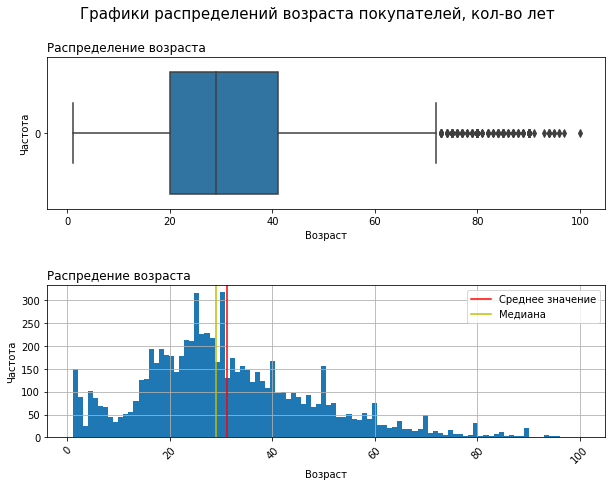

In [18]:
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(10,7))

plt.suptitle('Графики распределений возраста покупателей, кол-во лет', fontsize=15)

sns.boxplot(data=data['real_age'], orient="h", ax=ax_box)
ax_box.set_title('Распределение возраста', loc='left')
ax_box.set_xlabel('Возраст')
ax_box.set_ylabel('Частота')

plt.subplots_adjust(hspace=0.5)


plt.hist(data['real_age'], bins=100)
plt.grid(True) 
plt.title(f'Распредение возраста', loc = 'left') 
plt.xlabel('Возраст') 
plt.ylabel('Частота') 
plt.xticks(rotation=45)
plt.axvline(data['real_age'].mean(), color='r', linestyle='-', 
            label='Среднее значение')
plt.axvline(data['real_age'].median(), color='y', linestyle='-', 
            label='Медиана')
plt.legend()


plt.show()

**Промежуточный вывод**

Импортировали необходимые для работы библиотеки. Загрузили данные с фото и метками. С помощью загрузчика ImageDataGenerator загрузили изображения.
75% данных изображения людей до 41 года. Максимальный возраст 100 лет (что может быть правдой), минимальный 1 год. 
Распределение близко к нормальному, но тем не менее скошено в право, возрастных покупателей меньше. Также вызывает подозрение всплеск покупателей с возрастом год и два. Это может исказить предсказания модели. Интуитивно понятно, что дети до 5-10 лет не являются покупателями. Видимо камера зафиксировала детей покупателей. На это стоит обратить внимание.

Исследуем размер данных.

In [19]:
features, target = next(gen_flow)
print(features.shape)

(20, 224, 224, 3)


По размеру данных определям, что имеем четырёхмерный тензор, в котором 20 изображения размером 224x224 с тремя цветовыми каналами.

Выведем 15 фотографий покупателей.

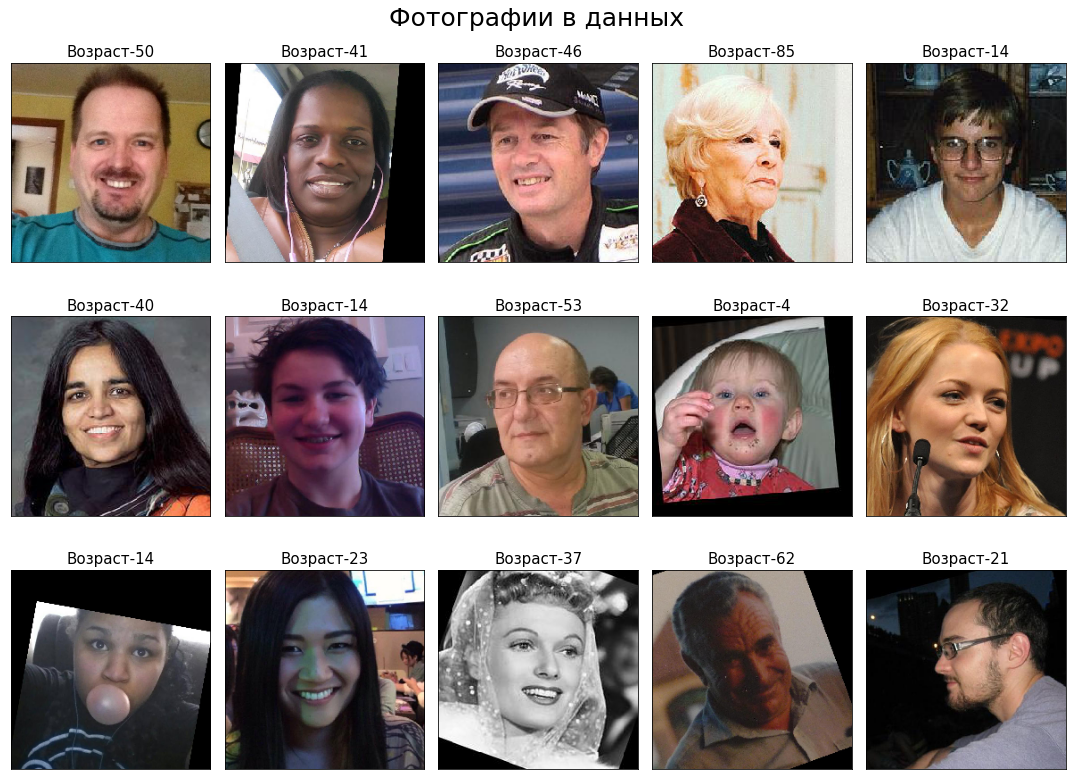

In [20]:
fig = plt.figure(figsize=(15,15))
for i in range(15):
    plt.suptitle('Фотографии в данных', fontsize=25)
    fig.add_subplot(4,5, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=15)
    plt.imshow(features[i])
    plt.xticks([])  
    plt.yticks([])  


    plt.tight_layout()

**Промежуточный вывод**

Возраст на фото на выборке в 16 фото соответствует реальности. Но также видим, что есть ч/б фото. Повторим, что внушает недоверие относительно большое количество детских фотографий. По всей видимости камера зафиксировала детей покупателей. Возможно стоит избавиться от этих данных, чтобы не вводить модель в заблуждение.

**Вывод по исследовательскому анализу данных**

Импортировали необходимые для работы библиотеки. Загрузили данные с фото и метками. С помощью загрузчика ImageDataGenerator загрузили изображения.
75% данных изображения людей до 41 года. Максимальный возраст 100 лет (что может быть правдой), минимальный 1 год. 
Распределение близко к нормальному, но тем не менее скошено в право, возрастных покупателей меньше. Также вызывает подозрение всплеск покупателей с возрастом год и два. Это может исказить предсказания модели. Интуитивно понятно, что дети до 5-10 лет не являются покупателями. Видимо камера зафиксировала детей покупателей. На это стоит обратить внимание.


Загрузили фото покупателей и добавили метки их возраста, чтобы понять корректность разметки данных. На выборке в 15 фотографий возраст соответствует фотографии.


## Обучение модели

Обучим нейронную сеть.

Перенесем сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd 


def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                      directory=path+'/final_files',    
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      subset='training',  
                                                      seed = 12345)
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = 12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
 >

```





**Результат обучения модели**

```

# < 178/178 - 125s - loss: 250.2212 - mae: 11.2817 - val_loss: 507.1095 - val_mae: 17.4364
Epoch 2/10
178/178 - 91s - loss: 92.5620 - mae: 7.2476 - val_loss: 681.7305 - val_mae: 21.1572
Epoch 3/10
178/178 - 91s - loss: 73.1055 - mae: 6.4803 - val_loss: 206.8707 - val_mae: 10.8228
Epoch 4/10
178/178 - 91s - loss: 60.6437 - mae: 5.9723 - val_loss: 136.3216 - val_mae: 8.7408
Epoch 5/10
178/178 - 91s - loss: 48.8868 - mae: 5.3798 - val_loss: 82.1053 - val_mae: 6.7867
Epoch 6/10
178/178 - 91s - loss: 40.6628 - mae: 4.9125 - val_loss: 74.3740 - val_mae: 6.3765
Epoch 7/10
178/178 - 91s - loss: 36.8565 - mae: 4.6662 - val_loss: 74.1712 - val_mae: 6.5899
Epoch 8/10
178/178 - 91s - loss: 32.5967 - mae: 4.3722 - val_loss: 97.0435 - val_mae: 7.3900
Epoch 9/10
178/178 - 91s - loss: 28.5944 - mae: 4.1157 - val_loss: 74.2166 - val_mae: 6.3509
Epoch 10/10
178/178 - 91s - loss: 24.2849 - mae: 3.8137 - val_loss: 92.3591 - val_mae: 7.4022
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 92.3591 - mae: 7.4022 >
# < длинные строки со скачиванием модели можно удалить >

```

**Промежуточный вывод**

Обучили модель на 10 эпохах. В ходе обучения удалось достигнуть качества модели, установленной заказчиков (МАЕ не выше 8).

## Анализ обученной модели

Обучили нейронную модель. Для обучения было сделано:

- импортированы необходимые библиотеки
- созданы функции для загрузки тренировочный и тестовых данных. Был использован загрузчик ImageDataGenerator
- произведена нормализация изображений (значение каждого пикселя поделено на 255, чтобы получить итоговые значения от 0 до 1)
- произведена разбивка на тренировочную и тестовую в выборку в размере 75 : 25
- для улучшения обучаемости модели произведена аугментация данных, а именно, развернули изображение в горизонтальной проекции horizontal_flip, сдвинули изображение по высоте height_shift_range=0.2 и ширине width_shift_range=0.2
- затем создали батчи по 32 изображения в каждом 
- далее создали модель. Использовали ResNet50 с весами imagenet
- include_top=True (англ. «добавить верхушку») — указание на то, что в конце архитектуры ResNet есть два слоя: GlobalAveragePooling2D и Dense. Если задать False, то этих слоёв не будет, и это наш случай.
- Последние слои:
- GlobalAveragePooling2D (англ. «глобальный двумерный пулинг усреднением») — пулинг с окном во весь тензор. Как и AveragePooling2D, возвращает среднее значение из группы пикселей внутри канала. GlobalAveragePooling2D нужен, чтобы усреднить информацию по всему изображению, то есть получить пиксель с большим количеством каналов (например, 512 для ResNet50).
- Dense — полносвязный слой для классификации.
- оптимизатор Adam (адаптивный шаг градиентного спуска)
- функция потерь MSE
- Целевой функцией для модели определена средняя абсолютная ошибка (MAE). Количество эпох обучения взято 10. Нам удалось добиться значения 7,4022, что ниже требуемой заказчиком.


## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы